# Admin

Parameters

In [1]:
#root_input_loc = 'C:\\Users\\fmqai\OneDrive\\Projects\\HackOn(Data)\\Competition\\Raw data\\'
root_input_loc = 'D:\\Raw data\\'

Libraries

In [2]:
import os
import pandas as pd
import math
import gzip
import numpy as np
import scipy.stats as stats
from scipy.sparse import csc_matrix, csr_matrix
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
import seaborn as sns; sns.set(style="white", color_codes=True)
import warnings 
import missingno

Other settings

In [3]:
%matplotlib inline
warnings.filterwarnings("ignore")

# Load data

Import reviews data

In [4]:
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
    
    if i > 50000:
         break
    else:
        continue
  return pd.DataFrame.from_dict(df, orient='index')

In [5]:
#reviews_df = getDF(root_input_loc + 'reviews_Books_5.json.gz')

# some data cleaning
#reviews_df['unixReviewTime'] = pd.to_datetime(reviews_df['unixReviewTime'],unit='s') #changing time format
#reviews_df.rename(columns={'unixReviewTime': 'reviewTime', 'asin': 'productID'}, inplace=True)

In [6]:
#reviews_df.head()

Import ratings data

In [7]:
ratings_df = pd.read_csv(filepath_or_buffer = root_input_loc + 'ratings_Books.csv'
                         , header=None
                         , names = ['user', 'productID', 'rating', 'timestamp']
                         , nrows = 50000)

In [8]:
ratings_df.head()

,user,productID,rating,timestamp
0,AH2L9G3DQHHAJ,0000000116,4.0,1019865600
1,A2IIIDRK3PRRZY,0000000116,1.0,1395619200
2,A1TADCM7YWPQ8M,0000000868,4.0,1031702400
3,AWGH7V0BDOJKB,0000013714,4.0,1383177600
4,A3UTQPQPM4TQO0,0000013714,5.0,1374883200


Import meta data

In [9]:
meta_df = getDF(root_input_loc + 'meta_Books.json.gz')

meta_df.rename(columns={'asin': 'productID'}, inplace=True)

In [10]:
meta_df.head()

,productID,salesRank,imUrl,categories,title,description,price,related
0,0001048791,{'Books': 6334800},http://ecx.images-amazon.com/images/I/51MKP0T4...,[[Books]],"The Crucible: Performed by Stuart Pankin, Jero...",NaN,NaN,NaN
1,0001048775,{'Books': 13243226},http://ecx.images-amazon.com/images/I/5166EBHD...,[[Books]],Measure for Measure: Complete &amp; Unabridged,William Shakespeare is widely regarded as the ...,NaN,NaN
2,0001048236,{'Books': 8973864},http://ecx.images-amazon.com/images/I/51DH145C...,[[Books]],The Sherlock Holmes Audio Collection,"&#34;One thing is certain, Sherlockians, put a...",9.26,"{'also_viewed': ['1442300191', '9626349786', '..."
3,0000401048,{'Books': 6448843},http://ecx.images-amazon.com/images/I/41bchvIf...,[[Books]],The rogue of publishers' row;: Confessions of ...,NaN,NaN,{'also_viewed': ['068240103X']}
4,0001019880,{'Books': 9589258},http://ecx.images-amazon.com/images/I/61LcHUdv...,[[Books]],Classic Soul Winner's New Testament Bible,NaN,5.39,"{'also_viewed': ['B003HMB5FC', '0834004593'], ..."


In [11]:
# find out how many rows

meta_df.count()

# 50,001 rows in total
# lets keep 35979 rows where description is not null

# export 
meta_df_filtered = meta_df[meta_df.description.notnull()]

meta_df_filtered.count()

#meta_df_filtered.to_json(path_or_buf='C:\\Users\\fmqai\\Desktop\\meta_Books_filtered.json')
#meta_df_filtered.to_csv(path_or_buf='C:\\Users\\fmqai\\Desktop\\meta_Books_filtered.csv')

productID      35979
salesRank      35950
imUrl          35875
categories     35979
title          35979
description    35979
price          31558
related        31702
dtype: int64

Import image features data

In [12]:
import struct

def readImageFeatures(path):
  f = open(path, 'rb')
  while True:
    asin = f.read(10)
    if asin == '': break
    feature = []
    for i in range(4096):
      feature.append(struct.unpack('f', f.read(4)))
    yield asin, feature

# EDA

In [15]:
all_data = pd.merge(ratings_df, meta_df, on=['productID'])
all_data['timestamp'] = pd.to_datetime(all_data['timestamp'], unit='s')

In [16]:
all_data.head(5)

,user,productID,rating,timestamp,salesRank,imUrl,categories,title,description,price,related
0,AH2L9G3DQHHAJ,0000000116,4.0,2002-04-27,{'Books': 10790794},http://ecx.images-amazon.com/images/I/51Rbg%2B...,[[Books]],Georgina Goodman Nelson Womens Size 8.5 Purple...,NaN,NaN,"{'also_viewed': ['B005U9T66K', 'B00602O7PG', '..."
1,A2IIIDRK3PRRZY,0000000116,1.0,2014-03-24,{'Books': 10790794},http://ecx.images-amazon.com/images/I/51Rbg%2B...,[[Books]],Georgina Goodman Nelson Womens Size 8.5 Purple...,NaN,NaN,"{'also_viewed': ['B005U9T66K', 'B00602O7PG', '..."
2,A1TADCM7YWPQ8M,0000000868,4.0,2002-09-11,{'Books': 14161827},http://ecx.images-amazon.com/images/I/41K1RtF0...,[[Books]],Foot Rot of Piper nigrum. L. (Phytopathologica...,NaN,21.85,NaN
3,AWGH7V0BDOJKB,0000013714,4.0,2013-10-31,{'Books': 64393},http://ecx.images-amazon.com/images/I/51M1p2do...,[[Books]],Heavenly Highway Hymns: Shaped-Note Hymnal,NaN,8.09,"{'also_bought': ['0005080789', '0005476798', '..."
4,A3UTQPQPM4TQO0,0000013714,5.0,2013-07-27,{'Books': 64393},http://ecx.images-amazon.com/images/I/51M1p2do...,[[Books]],Heavenly Highway Hymns: Shaped-Note Hymnal,NaN,8.09,"{'also_bought': ['0005080789', '0005476798', '..."


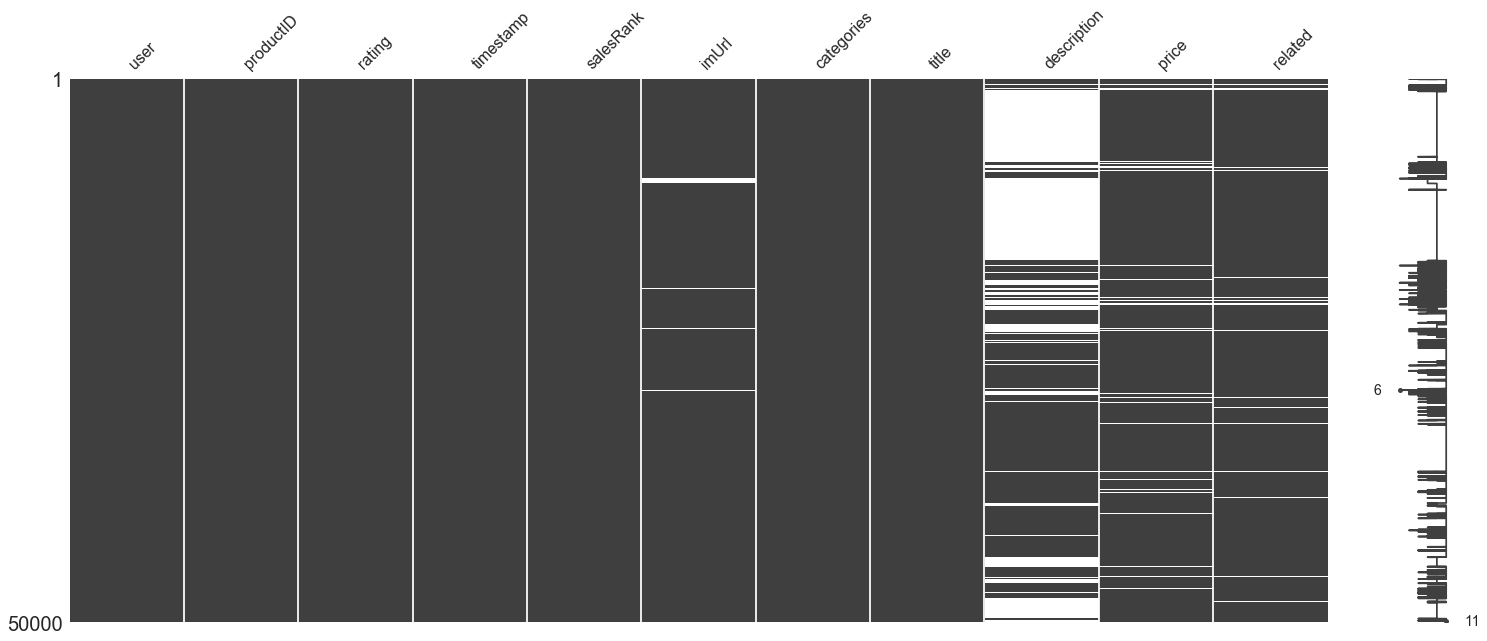

In [26]:
missingno.matrix(all_data, freq=False)

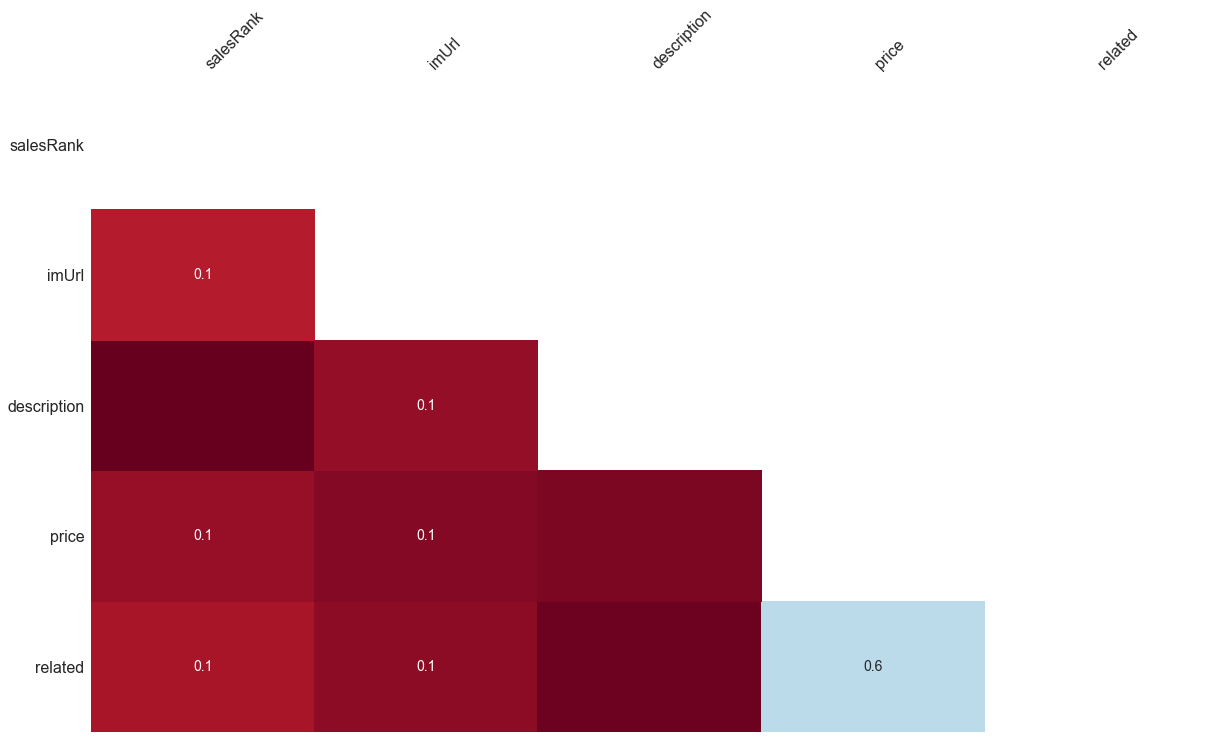

In [28]:
missingno.heatmap(all_data)

In [ ]:
null_pattern = (np.random.random(1000).reshape((50, 20)) > 0.5).astype(bool)
null_pattern = pd.DataFrame(null_pattern).replace({False: None})
msno.matrix(null_pattern.set_index(pd.period_range('1/1/2011', '2/1/2015', freq='M')) , freq='BQ')

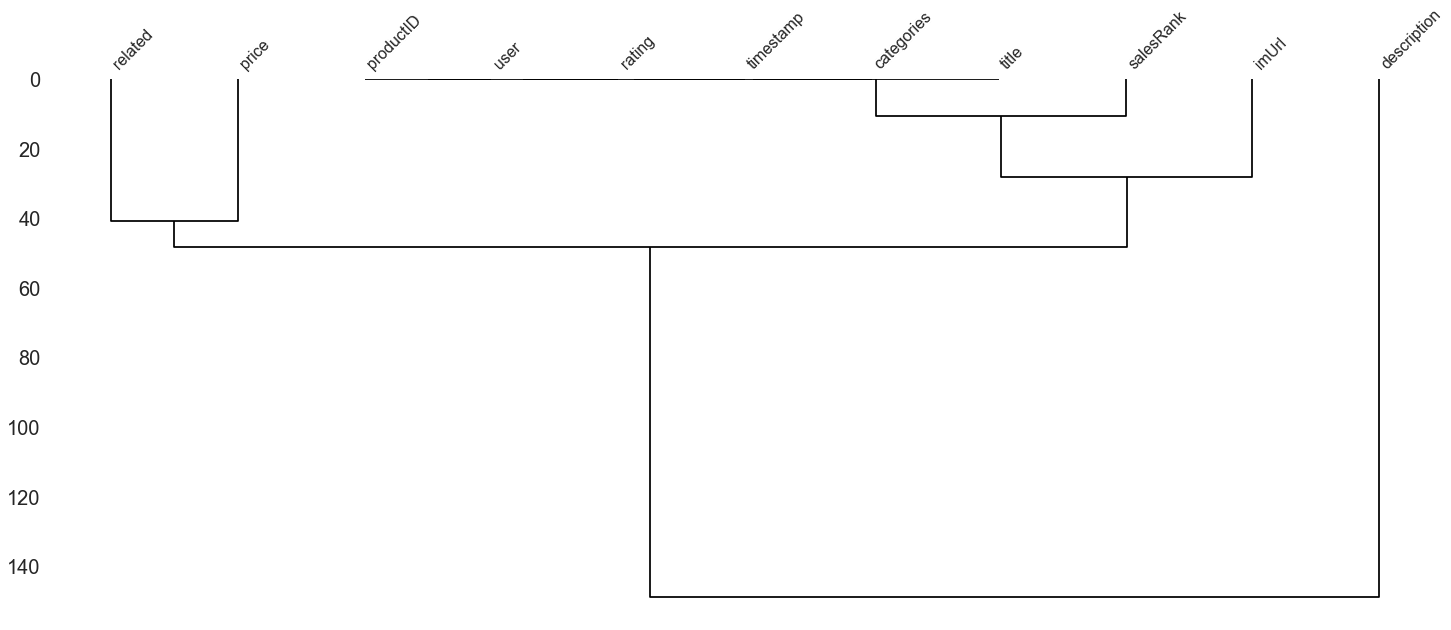

In [29]:
missingno.dendrogram(all_data)

# Data Preparation

# Non-personalized RS

This will be a popularity based model, i.e. all users get the same reccomendations based on the most popular choices. 

# CB RS

In [16]:
import pandas as pd
import time
import redis
from flask import current_app
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [19]:
def info(msg):
    current_app.logger.info(msg)

In [22]:
class CBEngine(object):

    SIMKEY = 'p:smlr:%s'

    def __init__(self):
        _self = self

    def train(self, data_source):
        start = time.time()
        ds = pd.read_csv(data_source)
        info("Training data ingested in %s seconds." % (time.time() - start))

        start = time.time()
        self._train(ds)
        info("Engine trained in %s seconds." % (time.time() - start))

    def _train(self, ds):
        """
        Train the engine.

        Create a TF-IDF matrix of unigrams, bigrams, and trigrams
        for each product. The 'stop_words' param tells the TF-IDF
        module to ignore common english words like 'the', etc.

        Then we compute similarity between all products using
        SciKit Leanr's linear_kernel (which in this case is
        equivalent to cosine similarity).

        Iterate through each item's similar items and store the
        100 most-similar. Stops at 100 because well...  how many
        similar products do you really need to show?

        Similarities and their scores are stored in redis as a
        Sorted Set, with one set for each item.

        :param ds: A pandas dataset containing two fields: description & id
        :return: Nothin!
        """

        tf = TfidfVectorizer(analyzer='word',
                             ngram_range=(1, 3),
                             min_df=0,
                             stop_words='english')
        
        tfidf_matrix = tf.fit_transform(ds['description'])

        cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

        for idx, row in ds.iterrows():
            similar_indices = cosine_similarities[idx].argsort()[:-100:-1]
            similar_items = [(cosine_similarities[idx][i], ds['id'][i])
                             for i in similar_indices]

            # First item is the item itself, so remove it.
            # This 'sum' is turns a list of tuples into a single tuple:
            # [(1,2), (3,4)] -> (1,2,3,4)
            flattened = sum(similar_items[1:], ())

    def predict(self, item_id, num):
        """
        Couldn't be simpler! Just retrieves the similar items and
        their 'score' from redis.

        :param item_id: string
        :param num: number of similar items to return
        :return: A list of lists like: [["19", 0.2203],
        ["494", 0.1693], ...]. The first item in each sub-list is
        the item ID and the second is the similarity score. Sorted
        by similarity score, descending.
        """

        return self.zrange(self.SIMKEY % item_id,
                              0,
                              num-1,
                              withscores=True,
                              desc=True)

content_engine = CBEngine()

# ALS RS

In [ ]:
# first we need to turn user and product IDs into categorical variables
reviews_df['reviewerID'] = reviews_df['reviewerID'].astype("category")
reviews_df['productID'] = reviews_df['productID'].astype("category")

In [ ]:
# then create a sparse matrix of all the user/product/rating triples
reviews_matrix = csr_matrix((reviews_df['overall'].astype(float), 
                   (reviews_df['reviewerID'].cat.codes,
                    reviews_df['productID'].cat.codes 
                    )))

In [ ]:
h = reviews_matrix.toarray()
rdd = sc.parallelize(h)
rdd.getNumPartitions()
ratings = rdd.map(lambda l: Rating(int(l[1]), int(l[2]), float(l[7])))

In [ ]:
def ALS_Spark(iterations, rank):
    """
    Function to pipeline the alternative least squares (ALS) using different parameters.
    Returns root mean square error (RMSE). 
    
    'Rank' is the number of latent factors in the model and 'iterations' is the number of
    of the model. 
    
    :input: int
    :output: float

    """
    rank = rank
    numIterations = iterations
    model = ALS.train(ratings, rank, numIterations)
    testdata = ratings.map(lambda p: (p[0], p[1]))
    predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
    ratesAndPreds = ratings.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)

    MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
    RMSE = np.sqrt(MSE)
    print "Using number of ranks = ", rank
    print "Using number of iterations = ", numIterations
    print("Mean Squared Error = " + str(MSE))
    print "RMSE = ", RMSE, '\n'
    return RMSE